In [3]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [147]:
# loading wide table
df_wide = pd.read_csv('../microservices/dash_app/wide.csv')
df_wide['datetime'] = pd.to_datetime(df_wide['hour'], format='%Y-%m-%d %H:%M:%S')
df_gamestop = df_wide.set_index('datetime')

train_org_df_wide = df_wide[df_gamestop.index.year == 2020]
test_org_df_wide = df_wide[df_gamestop.index.year == 2021]
test_org_df_wide.head()

,hour,avg_all_post_pos,avg_all_post_neg,avg_all_post_neu,cnt_all_user,cnt_all_tag,cnt_all_post,cnt_all_comments,avg_gme_post_pos,avg_gme_post_neg,...,cnt_gme_post,cnt_gme_comments,id,volume,openprice,closeprice,highprice,lowprice,prediction,datetime
4560,2021-01-04 00:00:00,0.079373,0.079935,0.833351,92.0,45.0,137.0,134.0,0.000001,0.000001,...,1.0,1.0,1604.0,1695.0,19.1,19.4,19.4,19.1,-1.0,2021-01-04 00:00:00
4561,2021-01-04 01:00:00,0.090065,0.086522,0.819869,147.0,62.0,280.0,277.0,0.120668,0.102334,...,3.0,3.0,1604.0,1695.0,19.1,19.4,19.4,19.1,-1.0,2021-01-04 01:00:00
4562,2021-01-04 02:00:00,0.103936,0.079856,0.813165,169.0,84.0,324.0,319.0,0.065751,0.007501,...,4.0,3.0,1604.0,1695.0,19.1,19.4,19.4,19.1,-1.0,2021-01-04 02:00:00
4563,2021-01-04 03:00:00,0.086609,0.081172,0.813798,120.0,56.0,217.0,211.0,0.000000,0.000000,...,0.0,0.0,1604.0,1695.0,19.1,19.4,19.4,19.1,-1.0,2021-01-04 03:00:00
4564,2021-01-04 04:00:00,0.117629,0.058659,0.811240,197.0,88.0,401.0,385.0,0.200501,0.000001,...,4.0,3.0,1604.0,1695.0,19.1,19.4,19.4,19.1,-1.0,2021-01-04 04:00:00


## Data Preprocessing

In [148]:
train_datetime_list = list(train_df_wide.index)
test_datetime_list = list(test_df_wide.index)
gamestop_datetime_list = list(df_wide.index)

feature_set_narrow = ["openprice", "highprice", "lowprice", "volume", "closeprice"]

feature_set_wide = [
    "avg_all_post_pos",
    "avg_all_post_neg",
    "avg_all_post_neu",
    "cnt_all_user",
    "cnt_all_tag",
    "cnt_all_post",
    "cnt_all_comments",
    "avg_gme_post_pos",
    "avg_gme_post_neg",
    "avg_gme_post_neu",
    "cnt_gme_user",
    "cnt_gme_tag",
    "cnt_gme_post",
    "cnt_gme_comments",
    "volume",
    "openprice",
    "highprice",
    "lowprice",
    "closeprice"
]

train_df_wide = train_org_df_wide[feature_set_wide]
test_df_wide = test_org_df_wide[feature_set_wide]

train_df_narrow = train_df_wide[feature_set_narrow]
test_df_narrow = test_df_wide[feature_set_narrow]

df_wide = df_gamestop[feature_set_wide]

<AxesSubplot:>

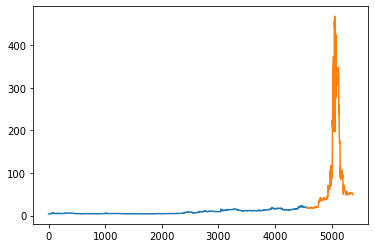

In [139]:
train_df_narrow['closeprice'].plot()
test_df_narrow['closeprice'].plot()

In [140]:
# finding missing values
train_df_wide.isnull().sum()

avg_all_post_pos    0
avg_all_post_neg    0
avg_all_post_neu    0
cnt_all_user        0
cnt_all_tag         0
cnt_all_post        0
cnt_all_comments    0
avg_gme_post_pos    0
avg_gme_post_neg    0
avg_gme_post_neu    0
cnt_gme_user        0
cnt_gme_tag         0
cnt_gme_post        0
cnt_gme_comments    0
volume              0
openprice           0
highprice           0
lowprice            0
closeprice          0
dtype: int64

In [141]:
test_df_wide.isnull().sum()

avg_all_post_pos    0
avg_all_post_neg    0
avg_all_post_neu    0
cnt_all_user        0
cnt_all_tag         0
cnt_all_post        0
cnt_all_comments    0
avg_gme_post_pos    0
avg_gme_post_neg    0
avg_gme_post_neu    0
cnt_gme_user        0
cnt_gme_tag         0
cnt_gme_post        0
cnt_gme_comments    0
volume              0
openprice           0
highprice           0
lowprice            0
closeprice          0
dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'avg_all_post_pos'),
  Text(1, 0, 'avg_all_post_neg'),
  Text(2, 0, 'avg_all_post_neu'),
  Text(3, 0, 'cnt_all_user'),
  Text(4, 0, 'cnt_all_tag'),
  Text(5, 0, 'cnt_all_post'),
  Text(6, 0, 'cnt_all_comments'),
  Text(7, 0, 'avg_gme_post_pos'),
  Text(8, 0, 'avg_gme_post_neg'),
  Text(9, 0, 'avg_gme_post_neu'),
  Text(10, 0, 'cnt_gme_user'),
  Text(11, 0, 'cnt_gme_tag'),
  Text(12, 0, 'cnt_gme_post'),
  Text(13, 0, 'cnt_gme_comments'),
  Text(14, 0, 'volume'),
  Text(15, 0, 'openprice'),
  Text(16, 0, 'highprice'),
  Text(17, 0, 'lowprice'),
  Text(18, 0, 'closeprice')])

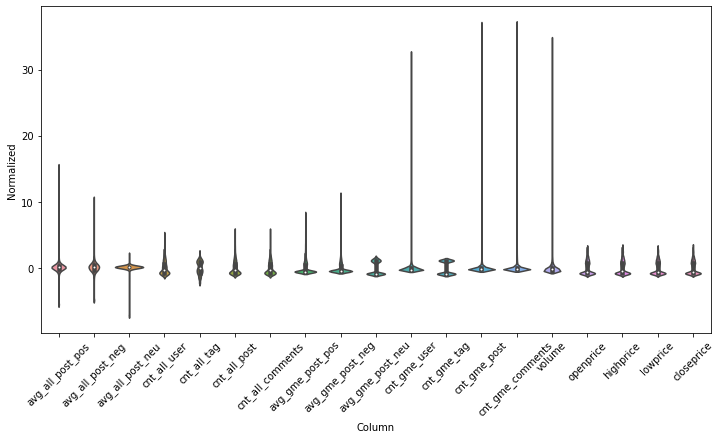

In [142]:
# Visualize the ditribution of the features in the train dataset
df_std = (train_df_wide - train_df_wide.mean()) / train_df_wide.std()
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'avg_all_post_pos'),
  Text(1, 0, 'avg_all_post_neg'),
  Text(2, 0, 'avg_all_post_neu'),
  Text(3, 0, 'cnt_all_user'),
  Text(4, 0, 'cnt_all_tag'),
  Text(5, 0, 'cnt_all_post'),
  Text(6, 0, 'cnt_all_comments'),
  Text(7, 0, 'avg_gme_post_pos'),
  Text(8, 0, 'avg_gme_post_neg'),
  Text(9, 0, 'avg_gme_post_neu'),
  Text(10, 0, 'cnt_gme_user'),
  Text(11, 0, 'cnt_gme_tag'),
  Text(12, 0, 'cnt_gme_post'),
  Text(13, 0, 'cnt_gme_comments'),
  Text(14, 0, 'volume'),
  Text(15, 0, 'openprice'),
  Text(16, 0, 'highprice'),
  Text(17, 0, 'lowprice'),
  Text(18, 0, 'closeprice')])

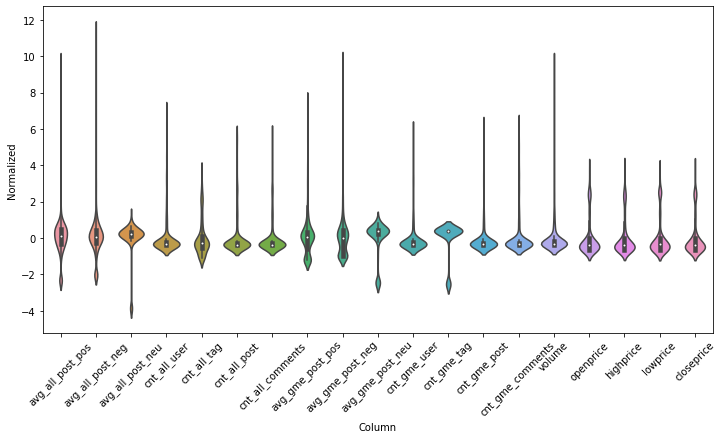

In [16]:
df_std = (test_df_wide - test_df_wide.mean()) / test_df_wide.std()
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
plt.xticks(rotation=45)

In [86]:
def scale(df, feature_set, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        scaled_arr = scaler.fit_transform(df[feature_set])
    else:
        scaled_arr = scaler.transform(df[feature_set])
    return scaled_arr, scaler

def split(train_arr, train_ratio):
    # split the data to train, validate
    n = len(train_arr)
    train_set = train_arr[:int(n*train_ratio)]
    val_set = train_arr[int(n*train_ratio):]
    return train_set, val_set

### Data Windowing for time series forecasting

> Refer to [Data Windowing](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing) for more details


In [103]:
# Generate time windows for time series forecasting with LSTM network
def generate_window(dataset, label, train_window, pred_horizon):
    dataset_seq = []
    size = len(dataset)
    x_arr = []
    y_arr = []
    for i in range(size - train_window - pred_horizon):
        x = dataset[i:(i+train_window), :]
        y = label[i+train_window+pred_horizon-1:i+train_window+pred_horizon]
        x_arr.append(x)
        y_arr.append(y)

    x_tensor = torch.tensor(x_arr).float()
    y_tensor = torch.tensor(y_arr).float()
    num_features = x_tensor.shape[2]
    dataset_seq = (x_tensor, y_tensor)
    return dataset_seq, num_features

def create_batch_set(dataset_seq, batch_size = 100):
    x_tensor, y_tensor = dataset_seq
    tensor_dataset = TensorDataset(x_tensor,y_tensor)
    tensor_dataloader = DataLoader(tensor_dataset, batch_size, False)
    return tensor_dataloader

In [126]:
# let's create sequential training dataset with various traning windows and prediction horizons
# given that the times series data has 1-hour resolution
# 24hours * (days)

train_window_list = [3, 5, 10, 24, 24*2, 24*5, 24*7]
prediction_horizon_list = [1, 2, 3, 5, 24*1, 24*2, 24*3]

# choose these set for testing 
train_window = train_window_list[3]
prediction_horizon = prediction_horizon_list[0]
print('train window: ', train_window)
print('prediction horizon: ', prediction_horizon)

label_train = train_df_wide['closeprice']
label_test = test_df_wide['closeprice']
label_all = df_wide['closeprice']

train_set, train_scaler = scale(train_df_wide, feature_set_wide)
target_set, _ = scale(test_df_wide, feature_set_wide, train_scaler)
train_set , val_set = split(train_set, 0.8)
label_train , label_val = split(label_train, 0.8)

gamestop_set, _ = scale(df_wide, feature_set_wide)

train_seq, num_features = generate_window(train_set, label_train, train_window, prediction_horizon)
val_seq, _ = generate_window(val_set, label_val, train_window, prediction_horizon)

x_train, _ =train_seq
x_val, _ = val_seq
train_batch_size = int(len(x_train)*0.5)
val_batch_size = int(len(x_val)*1)

train_batches = create_batch_set(train_seq, batch_size=200)
val_batches = create_batch_set(val_seq, batch_size=2)

target_seq, _ = generate_window(target_set, label_test, train_window, prediction_horizon)
gamestop_seq, _ = generate_window(gamestop_set, label_all, train_window, prediction_horizon)

datetime_target = test_datetime_list[train_window+prediction_horizon:]
datetime_gamestop = gamestop_datetime_list[train_window+prediction_horizon:]


train window:  24
prediction horizon:  1


## Creating LSTM Network

In [127]:
class LSTM(nn.Module):
    def __init__(self, input_size, seq_length, hidden_size=100, num_layers = 2, output_size=1):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.seq_len = seq_length
        
        self.hidden_state = None
        self.cell_state = None
        self.hidden = (self.hidden_state, self.cell_state)

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True
        )

        self.linear = nn.Linear(self.hidden_size * self.seq_len, self.output_size)

    def init_hidden(self, batch_size, device):
        self.hidden_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size).to(device)
        self.cell_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size).to(device)
        self.hidden = (self.hidden_state, self.cell_state)

    def forward(self, x):
        lstm_out, self.hidden = self.lstm(
                x,
                self.hidden
            )
        outputs = self.linear(lstm_out.reshape(x.size(0),-1))
        return outputs


## Traning LSTM model

In [128]:
def train_model(model, device, train_batches, val_batches=None, num_epochs=50):

    learning_rate = 1e-3
    train_losses = []
    val_losses = []
    best_loss = np.Inf
    val_loss = None
    

    criterion = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        batch_losses = []
        for batch_ndx, train_batch in enumerate(train_batches):
            model.train()
            x_train, y_train = train_batch
            batch_size = x_train.size(0)
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            model.init_hidden(batch_size, device)
            outputs = model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            batch_loss = loss.item()
            batch_losses.append(batch_loss)
            
        if val_batches is not None:
            model.eval()
            with torch.no_grad():
                val_batch_losses = []
                for _, val_batch in enumerate(val_batches):
                    x_val, y_val = val_batch
                    batch_size = x_val.size(0)
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    model.init_hidden(batch_size, device)
                    pred = model(x_val)
                    loss = criterion(pred, y_val)
                    val_loss = loss.item()
                    val_batch_losses.append(val_loss)
                    if val_loss < best_loss:
                        best_loss = val_loss
        
        val_losses_mean = np.mean(val_batch_losses)
        batch_losses_mean = np.mean(batch_losses)
        print(f"Epoch {epoch}: train loss {batch_losses_mean}, val loss {val_losses_mean}")
        val_losses.append(val_losses_mean)
        train_losses.append(batch_losses_mean)
        
        
    return model.eval(), train_losses, val_losses

In [129]:
# RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)
# torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = LSTM(input_size=num_features, seq_length=train_window)
model.to(device)

model, train_losses, val_losses = train_model(model, device, train_batches, val_batches, num_epochs=120)

cuda
Epoch 0: train loss 27.826496356411983, val loss 92.90375926121565
Epoch 1: train loss 92.3711461111119, val loss 151.64755530829902
Epoch 2: train loss 21.59413937518471, val loss 79.82347443726685
Epoch 3: train loss 1.258219930294313, val loss 10.636732514388388
Epoch 4: train loss 1.5201097277826385, val loss 8.588120398778342
Epoch 5: train loss 0.7002665376976916, val loss 7.865236783595252
Epoch 6: train loss 0.7595940473440447, val loss 7.011475153783387
Epoch 7: train loss 0.42411488804378006, val loss 6.985796125327357
Epoch 8: train loss 0.7503094134950324, val loss 6.554233087741772
Epoch 9: train loss 1.1261870212068683, val loss 8.865161802925549
Epoch 10: train loss 2.5492587532652053, val loss 14.090750970198092
Epoch 11: train loss 1.597837527723689, val loss 6.667314006962385
Epoch 12: train loss 1.4246355899070438, val loss 8.236458482239843
Epoch 13: train loss 1.4573726371714943, val loss 6.65859931316329
Epoch 14: train loss 0.6745603470817992, val loss 5.999

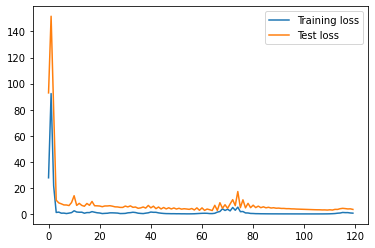

In [130]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Test loss")
plt.legend()

## Predictions

In [131]:
observed, predicted, losses = [], [], []
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
criterion = nn.L1Loss(reduction='sum').to(device)
model.to(device)
print(device)

X_test, y_test = target_seq
test_set_size = X_test.size(0)

# model.init_hidden(X_test.size(0), device)
# y_pred = model(X_test)

with torch.no_grad():
    model.eval()
    for i in range(test_set_size):
        x_i = X_test[i:i+1]
        y_i = y_test[i:i+1]
        x_i.to(device)
        y_i.to(device)
        model.init_hidden(x_i.size(0), device)
        y_pred = model(x_i)
        loss = criterion(y_pred, y_i)
        predicted.append(y_pred.item())
        test_org_df_wide.at[datetime_target[i], 'prediction'] = y_pred.item()
        losses.append(loss.item())
        
observed = y_test.cpu().numpy().flatten()
# predictions = y_pred.cpu().numpy().flatten()
predictions = np.array(predicted).flatten()

test_org_df_wide.head(50)

cpu


,hour,avg_all_post_pos,avg_all_post_neg,avg_all_post_neu,cnt_all_user,cnt_all_tag,cnt_all_post,cnt_all_comments,avg_gme_post_pos,avg_gme_post_neg,...,cnt_gme_tag,cnt_gme_post,cnt_gme_comments,id,volume,openprice,closeprice,highprice,lowprice,prediction
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00,2021-01-04 00:00:00,0.079373,0.079935,0.833351,92.0,45.0,137.0,134.0,0.000001,0.000001,...,1.0,1.0,1.0,1604.0,1695.0,19.100,19.400,19.40,19.100,-1.000000
2021-01-04 01:00:00,2021-01-04 01:00:00,0.090065,0.086522,0.819869,147.0,62.0,280.0,277.0,0.120668,0.102334,...,1.0,3.0,3.0,1604.0,1695.0,19.100,19.400,19.40,19.100,-1.000000
2021-01-04 02:00:00,2021-01-04 02:00:00,0.103936,0.079856,0.813165,169.0,84.0,324.0,319.0,0.065751,0.007501,...,1.0,4.0,3.0,1604.0,1695.0,19.100,19.400,19.40,19.100,-1.000000
2021-01-04 03:00:00,2021-01-04 03:00:00,0.086609,0.081172,0.813798,120.0,56.0,217.0,211.0,0.000000,0.000000,...,0.0,0.0,0.0,1604.0,1695.0,19.100,19.400,19.40,19.100,-1.000000
2021-01-04 04:00:00,2021-01-04 04:00:00,0.117629,0.058659,0.811240,197.0,88.0,401.0,385.0,0.200501,0.000001,...,1.0,4.0,3.0,1604.0,1695.0,19.100,19.400,19.40,19.100,-1.000000
2021-01-04 05:00:00,2021-01-04 05:00:00,0.094568,0.060318,0.845126,70.0,44.0,120.0,117.0,0.331001,0.000001,...,1.0,2.0,2.0,1604.0,1695.0,19.100,19.400,19.40,19.100,-1.000000
2021-01-04 06:00:00,2021-01-04 06:00:00,0.106618,0.106997,0.786396,137.0,58.0,253.0,246.0,0.092668,0.000001,...,1.0,3.0,3.0,1604.0,1695.0,19.100,19.400,19.40,19.100,-1.000000
2021-01-04 07:00:00,2021-01-04 07:00:00,0.078124,0.081857,0.833992,179.0,59.0,333.0,325.0,0.090334,0.009334,...,1.0,6.0,6.0,1604.0,1695.0,19.100,19.400,19.40,19.100,-1.000000
2021-01-04 08:00:00,2021-01-04 08:00:00,0.088263,0.062931,0.842984,105.0,41.0,172.0,167.0,0.024001,0.068251,...,1.0,4.0,2.0,1604.0,1695.0,19.100,19.400,19.40,19.100,-1.000000


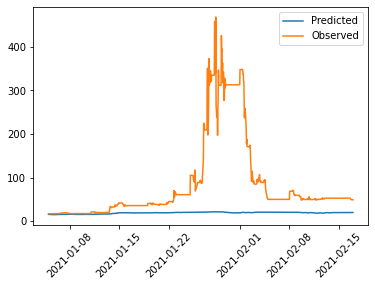

In [132]:

plt.plot(datetime_target,predictions, label="Predicted")
plt.plot(datetime_target, observed, label="Observed")
plt.xticks(rotation=45)
plt.legend()

69.55519503920178

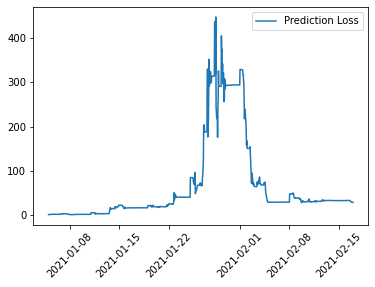

In [133]:
plt.plot(datetime_target ,losses, label="Prediction Loss")
plt.xticks(rotation=45)
plt.legend()
np.mean(losses)

<AxesSubplot:xlabel='datetime'>

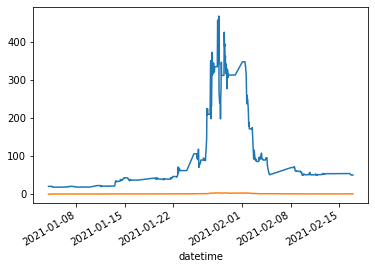

In [53]:
test_org_df_wide['closeprice'].plot()
test_org_df_wide['prediction'].plot()

In [149]:
# saving prediciton result as csv file for the entire dataset
truth, predictions, losses = [], [], []
device = torch.device("cpu")
criterion = nn.L1Loss(reduction='sum').to(device)
model.to(device)

X_test, y_test = gamestop_seq
test_set_size = X_test.size(0)

df_gamestop['prediction'] = np.nan

with torch.no_grad():
    model.eval()
    for i in range(test_set_size):
        x_i = X_test[i:i+1]
        y_i = y_test[i:i+1]
        x_i.to(device)
        y_i.to(device)
        model.init_hidden(x_i.size(0), device)
        y_pred = model(x_i)
        loss = criterion(y_pred, y_i)
        df_gamestop.at[datetime_gamestop[i], 'prediction'] = y_pred.item()
        predictions.append(y_pred.item())
        losses.append(loss.item())
        
        
truth = y_test.cpu().numpy().flatten()

In [153]:
df_gamestop.to_csv('../foobar/data/processed/wide.csv')
print('The wide table is updated with the prediction results')

The wide table is updated with the prediction results


In [ ]:
plt.plot(datetime_gamestop,predictions, label="Predictions")
plt.plot(datetime_gamestop, truth, label="Truth")
plt.xticks(rotation=45)
plt.legend()

In [154]:
print('Saving...')
state = {
    'model': model.state_dict(),
    'scaler': train_scaler,
    'feature_set': feature_set_wide,
    'train_loss': train_losses,
    'val_loss': val_losses,
    'pred_horizon': prediction_horizon,
    'train_window': train_window
}

if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
torch.save(state, f'./checkpoint/m2.pth')

Saving...


In [ ]:
import os

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_index = 0
for train_window in train_window_list:
    for prediction_horizon in prediction_horizon_list:
#         for feature_set in feature_sets:
        if prediction_horizon > train_window:
            break
            
#         train_set, train_scaler = scale(df_train, feature_set)
#         target_set, _ = scale(df_target, feature_set, train_scaler)
#         train_set , val_set = split(train_set, 0.8)
        
        
#         train_seq, num_features = generate_window(train_set, train_window, prediction_horizon)
#         val_seq, _ = generate_window(val_set, train_window, prediction_horizon)

#         train_batches = create_batch_set(train_seq)
#         val_batches = create_batch_set(val_seq)

#         target_seq, _ = generate_window(target_set, train_window, prediction_horizon)
#         gamestop_seq, _ = generate_window(gamestop_set, train_window, prediction_horizon)

#         datetime_target = target_datetime_list[train_window+prediction_horizon:]
#         datetime_gamestop = gamestop_datetime_list[train_window+prediction_horizon:]

        
#         train_seq, num_features = generate_window(train_set, train_window, prediction_horizon)
#         val_seq, _ = generate_window(val_set, train_window, prediction_horizon)
#         target_seq, _ = generate_window(target_set, train_window, prediction_horizon)

        datetime_target = target_datetime_list[train_window+prediction_horizon:]
        
        model = LSTM(input_size=num_features, seq_length=train_window)
        model = model.to(device)

        model, history, _ = train_model(model, device, train_seq, val_seq, num_epochs=100)
        visualization(history)
        model_index += 1

        print('Saving...')
        state = {
            'model': model.state_dict(),
            'scaler': train_scaler,
            'feature_set': feature_set,
            'history': history,
            'pred_horizon': prediction_horizon,
            'train_window': train_window
        }

        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'./checkpoint/train_m{model_index}.pth')

            
        plt.plot(history['train'], label="Training loss")
        plt.plot(history['val'], label="Test loss")
        plt.legend()
        
        truth, predictions, losses = [], [], []

        criterion = nn.L1Loss(reduction='sum').to(device)
        model.to(device)

        X_test, y_test = target_seq
        test_set_size = X_test.size(0)

        with torch.no_grad():
            model.eval()
            for i in range(test_set_size):
                x_i = X_test[i:i+1]
                y_i = y_test[i:i+1]
                x_i.to(device)
                y_i.to(device)
                model.init_hidden(x_i.size(0), device)
                y_pred = model(x_i)
                predictions.append(y_pred.cpu().numpy().flatten())
                loss = criterion(y_pred, y_i)
                losses.append(loss.item())

        truth = y_test.cpu().numpy().flatten()
        predictions = np.array(predictions).flatten()
        
        plt.plot(datetime_target,predictions, label="Predictions")
        plt.plot(datetime_target, truth, label="Truth")
        plt.xticks(rotation=45)
        plt.legend()